In [44]:
import matplotlib.pyplot as plt
import plotly.express as px

from transformers import GPT2LMHeadModel

In [45]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
sd_hf = model_hf.state_dict()
for k, v in sd_hf.items():
    print(f"{k:35} {v.shape}")

transformer.wte.weight              torch.Size([50257, 768])
transformer.wpe.weight              torch.Size([1024, 768])
transformer.h.0.ln_1.weight         torch.Size([768])
transformer.h.0.ln_1.bias           torch.Size([768])
transformer.h.0.attn.c_attn.weight  torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias    torch.Size([2304])
transformer.h.0.attn.c_proj.weight  torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias    torch.Size([768])
transformer.h.0.ln_2.weight         torch.Size([768])
transformer.h.0.ln_2.bias           torch.Size([768])
transformer.h.0.mlp.c_fc.weight     torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias       torch.Size([3072])
transformer.h.0.mlp.c_proj.weight   torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias     torch.Size([768])
transformer.h.1.ln_1.weight         torch.Size([768])
transformer.h.1.ln_1.bias           torch.Size([768])
transformer.h.1.attn.c_attn.weight  torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias    to

In [46]:
sd_hf["transformer.wpe.weight"].view(-1).shape, sd_hf["transformer.wpe.weight"].view(-1)[:20]

(torch.Size([786432]),
 tensor([-0.0188, -0.1974,  0.0040,  0.0113,  0.0638, -0.1050,  0.0369, -0.1680,
         -0.0491, -0.0565, -0.0025,  0.0135, -0.0042,  0.0151,  0.0166, -0.1381,
         -0.0063, -0.0461,  0.0267, -0.2042]))

In [47]:
# Makes the notebook unnecessarily big!
# # px.imshow(sd_hf["transformer.wpe.weight"], color_continuous_scale="gray")

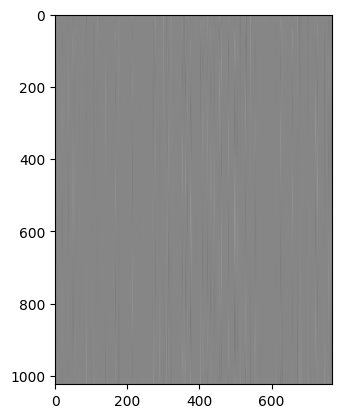

In [50]:
plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")
plt.show()

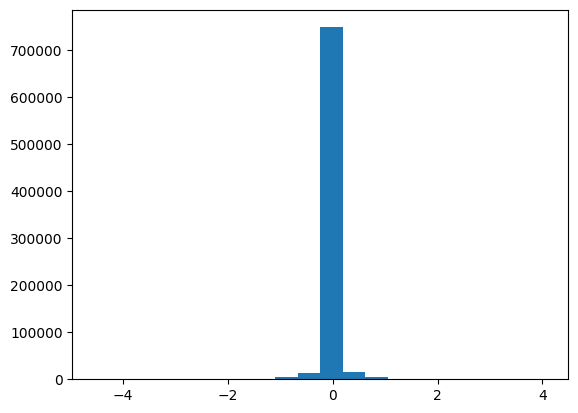

In [48]:
plt.hist(sd_hf["transformer.wpe.weight"].view(-1), bins=20)
plt.show()

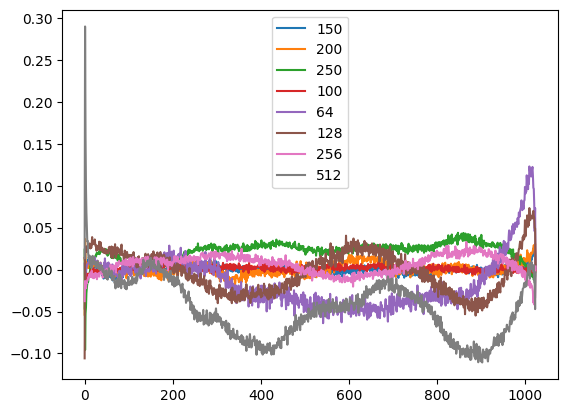

In [6]:
idx_list = [150, 200, 250, 100, 64, 128, 256, 512]
for i in idx_list:
    plt.plot(sd_hf["transformer.wpe.weight"][:, i])
plt.legend(idx_list)
plt.show()

In [51]:
# Makes the notebook unnecessarily big!
# px.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:300,:300], color_continuous_scale="gray")

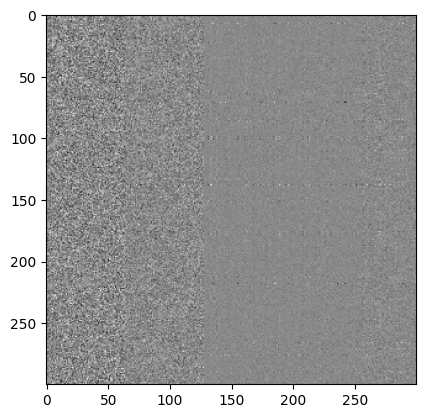

In [52]:
plt.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:300,:300], cmap="gray")
plt.show()

In [53]:
from transformers import pipeline, set_seed
generator = pipeline("text-generation", model="gpt2")
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, so it'd be hard to say anything about how to call a function. To put it another way, I"},
 {'generated_text': "Hello, I'm a language model, how could you not? But I need to know how to program that model in javascript. I am thinking about"},
 {'generated_text': "Hello, I'm a language model, a language model.\n\n[Laughs.]\n\n[Laughs.]\n\nThat would be a little weird"},
 {'generated_text': 'Hello, I\'m a language model, for example," he quipped once, as the next two paragraphs faded to black and purple.\n\nOn'},
 {'generated_text': 'Hello, I\'m a language model, and I\'m trying a new tool called "Java." Why can\'t I use jQuery? The best thing about'}]

In [54]:
import tiktoken
import torch
from torch.nn import functional as F

num_return_sequences = 5
max_length = 30

model = model_hf.to("cuda")

model.eval()
enc = tiktoken.get_encoding("gpt2")
tokens = enc.encode("Hello, I'm  language model,")
tokens = torch.tensor(tokens, dtype=torch.long)  # (8, )
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)  # (5, 8)
print(tokens)
x = tokens.to("cuda")

# generate - x = (B, T)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
while x.size(1) < max_length:
    # forward
    with torch.no_grad():
        logits = model(x)["logits"]
        # print(logits.size())
        logits = logits[:, -1, :]  # last pos logits (B, vocab_size)
        probs = F.softmax(logits, dim=-1)  # logits -> probabilities
        # top-k sampling 50 (hf pipeline default)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)  # both (5, 50)
        # sample with the topk_probs
        ix = torch.multinomial(topk_probs, 1)  # (B, 1)
        # gather - check docs >
        xcol = torch.gather(topk_indices, -1, ix)  # (B, 1)
        # append to sequence
        x = torch.cat((x, xcol), dim=1)

# print
for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(">", decoded)


tensor([[15496,    11,   314,  1101,   220,  3303,  2746,    11],
        [15496,    11,   314,  1101,   220,  3303,  2746,    11],
        [15496,    11,   314,  1101,   220,  3303,  2746,    11],
        [15496,    11,   314,  1101,   220,  3303,  2746,    11],
        [15496,    11,   314,  1101,   220,  3303,  2746,    11]])
> Hello, I'm  language model, I'm going to be doing it here by me.

A second question is this: I've done
> Hello, I'm  language model, now can I use    me?  That question was brought up a while ago on reddit about a
> Hello, I'm  language model, and I see all the features of  language : what is there in  language ? I want to know what
> Hello, I'm  language model, I work with a lot of different languages and one of the biggest factors is how they can translate into human language
> Hello, I'm  language model, you see. My name is I know my first computer, right? When I get a new computer I don


In [55]:
with open("tinyshakespeare.txt", "r") as f:
    data = f.read()
print(data[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [56]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")
tokens = enc.encode(data)
print(tokens[:24])

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


In [57]:
import torch
buf = torch.tensor(tokens[:24 + 1])
x = buf[:-1].view(4, 6)
y = buf[1:].view(4, 6)
print(x)
print(y)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


In [58]:
print(enc.decode(tokens[1024*23:1024*23 + 1024 + 1]))

.

CORIOLANUS:
No, I'll die here.
There's some among you have beheld me fighting:
Come, try upon yourselves what you have seen me.

MENENIUS:
Down with that sword! Tribunes, withdraw awhile.

BRUTUS:
Lay hands upon him.

COMINIUS:
Help Marcius, help,
You that be noble; help him, young and old!

Citizens:
Down with him, down with him!

MENENIUS:
Go, get you to your house; be gone, away!
All will be naught else.

Second Senator:
Get you gone.

COMINIUS:
Stand fast;
We have as many friends as enemies.

MENENIUS:
Sham it be put to that?

First Senator:
The gods forbid!
I prithee, noble friend, home to thy house;
Leave us to cure this cause.

MENENIUS:
For 'tis a sore upon us,
You cannot tent yourself: be gone, beseech you.

COMINIUS:
Come, sir, along with us.

CORIOLANUS:
I would they were barbarians--as they are,
Though in Rome litter'd--not Romans--as they are not,
Though calved i' the porch o' the Capitol--

MENENIUS:
Be gone;
Put not your worthy rage into your tongue;
One time will owe

In [59]:
print(sd_hf["lm_head.weight"].shape)
print(sd_hf["transformer.wte.weight"].shape)

torch.Size([50257, 768])
torch.Size([50257, 768])


In [60]:
(sd_hf["lm_head.weight"] == sd_hf["transformer.wte.weight"]).all()

tensor(True)

In [61]:
print(sd_hf["lm_head.weight"].data_ptr())
print(sd_hf["transformer.wte.weight"].data_ptr())

2551080550656
2551080550656


### Std dev grows indide the residual stream

In [62]:
x = torch.zeros(768)
n = 100 # 100 layers
for i in range(n):
    x += torch.randn(768)

print(x.std())

tensor(9.8504)


In [63]:
x = torch.zeros(768)
n = 100 # 100 layers
for i in range(n):
    x += n**-0.5 * torch.randn(768)

print(x.std())

tensor(1.0324)


### LR Scheduler with Cosine decay

In [66]:
import math

max_lr = 6e-4
min_lr = max_lr * 0.1
warmup_steps = 10
max_steps = 50

def get_lr(it):
    # 1) linear warmup for warmup_steps
    if it < warmup_steps:
        return max_lr * (it + 1) / warmup_steps
    # 2) flat tail after max_steps
    if it > max_steps:
        return min_lr
    # 3) in between, cosine decay till min_lr
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (
        1.0 + math.cos(math.pi * decay_ratio)
    )  # coeff starts at 1 and goes to 0
    # this makes a sharp corner (discontinuity)
    # coeff = math.cos(math.pi * decay_ratio / 2)
    # print(f"{decay_ratio:.3f} |  {math.cos(math.pi * decay_ratio):.3f} | {math.cos(math.pi * decay_ratio / 2):.3f} | {coeff:.3f}")
    return min_lr + coeff * (max_lr - min_lr)

In [67]:
x = torch.arange(0, 100)
y = [get_lr(i) for i in x]
px.line(x=x, y=y)

In [68]:
x = torch.arange(0, 100)
y = [math.cos(math.pi * (it - warmup_steps) / (max_steps - warmup_steps)) for it in x]
px.line(x=x, y=y)

### fused AdamW

In [69]:
import inspect
inspect.signature(torch.optim.AdamW).parameters

mappingproxy({'params': <Parameter "params: Union[Iterable[torch.Tensor], Iterable[Dict[str, Any]]]">,
              'lr': <Parameter "lr: Union[float, torch.Tensor] = 0.001">,
              'betas': <Parameter "betas: Tuple[float, float] = (0.9, 0.999)">,
              'eps': <Parameter "eps: float = 1e-08">,
              'weight_decay': <Parameter "weight_decay: float = 0.01">,
              'amsgrad': <Parameter "amsgrad: bool = False">,
              'maximize': <Parameter "maximize: bool = False">,
              'foreach': <Parameter "foreach: Optional[bool] = None">,
              'capturable': <Parameter "capturable: bool = False">,
              'differentiable': <Parameter "differentiable: bool = False">,
              'fused': <Parameter "fused: Optional[bool] = None">})

### Grad Accum

In [70]:
import torch 
torch.random.manual_seed(42) 

net = torch.nn.Sequential(
    torch.nn.Linear(16, 32),
    torch.nn.GELU(),
    torch.nn.Linear(32, 1)
)

x = torch.randn(4, 16)
y = torch.randn(4, 1)
net.zero_grad()
yhat = net(x)
loss = torch.nn.functional.mse_loss(yhat, y)
loss.backward()
print(loss)
print(net[0].weight.grad.view(-1)[:10])

# loss obj is due to reduction='mean'
# L = 1/4 * [
#         (y[0] - yhat[0])**2 +
#         (y[1] - yhat[1])**2 +
#         (y[2] - yhat[2])**2 +
#         (y[3] - yhat[3])**2 +
# ]
# NOTE : 1/4

tensor(0.7315, grad_fn=<MseLossBackward0>)
tensor([-0.0556, -0.0415,  0.0208,  0.0922, -0.0034, -0.1156,  0.1279,  0.0024,
         0.1107, -0.0587])


In [71]:
import torch 
torch.random.manual_seed(42) 

net = torch.nn.Sequential(
    torch.nn.Linear(16, 32),
    torch.nn.GELU(),
    torch.nn.Linear(32, 1)
)

x = torch.randn(4, 16)
y = torch.randn(4, 1)
loss_accum = 0.0
net.zero_grad()
for i in range(4):
    yhat = net(x[i])
    loss = torch.nn.functional.mse_loss(yhat, y[i])
    print(loss)
    loss = loss / 4 # NOTE : without this 1/4 is lost!
    loss_accum += loss.detach()
    print(loss, loss_accum)
    loss.backward()
    print(loss, loss_accum)
    print()

print()
print(loss, loss_accum)
print(net[0].weight.grad.view(-1)[:10])

# loss obj is due to reduction='mean'
#         (y[0] - yhat[0])**2
#         (y[1] - yhat[1])**2
#         (y[2] - yhat[2])**2
#         (y[3] - yhat[3])**2
# L = L0 + L1 + L2 + L3
# NOTE : 1/4 is lost!

tensor(0.0014, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<DivBackward0>) tensor(0.0003)
tensor(0.0003, grad_fn=<DivBackward0>) tensor(0.0003)

tensor(2.6965, grad_fn=<MseLossBackward0>)
tensor(0.6741, grad_fn=<DivBackward0>) tensor(0.6745)
tensor(0.6741, grad_fn=<DivBackward0>) tensor(0.6745)

tensor(0.0344, grad_fn=<MseLossBackward0>)
tensor(0.0086, grad_fn=<DivBackward0>) tensor(0.6831)
tensor(0.0086, grad_fn=<DivBackward0>) tensor(0.6831)

tensor(0.1937, grad_fn=<MseLossBackward0>)
tensor(0.0484, grad_fn=<DivBackward0>) tensor(0.7315)
tensor(0.0484, grad_fn=<DivBackward0>) tensor(0.7315)


tensor(0.0484, grad_fn=<DivBackward0>) tensor(0.7315)
tensor([-0.0556, -0.0415,  0.0208,  0.0922, -0.0034, -0.1156,  0.1279,  0.0024,
         0.1107, -0.0587])
